# solveODE

*solveODE* is a function created to compute and solve a differential equations system. It takes the simbolic equations create from *simbODE* and replaces variables with their respective numeric values.

In [12]:
#requiered packages
import simsysbio as s2b 
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import odeint

First, let's define the biological systems and find the differential equations system

In [13]:
####### Determine the differential equations system
#molecular species
species = ['mRNA', 'Protein']

#reagent and product matrices
reagents = np.array([[0, 1, 1, 0],[0, 0, 0, 1]])
products = np.array([[1, 0, 1, 0],[0, 0, 1, 0]])

#kinetic parameters
parameters = ['c1', 'c2', 'c3', 'c4']

#system input. It affects first reaction
inp = 'U'
idxR = 1

#gets simbolic differential equations 
equations, variables = s2b.simbODE(species, reagents, products, parameters,
                                   inputN=inp)

#muestra las ODEs obtenidas
for s in range(0, len(species)):
    print(f'd{species[s]}/dt:', equations[s])
  
print(variables)

dmRNA/dt: U*c1 - c2*mRNA
dProtein/dt: -Protein*c4 + c3*mRNA
{'species': [mRNA, Protein], 'pars': array([c1, c2, c3, c4], dtype=object), 'nameVar': array([U, mRNA, Protein], dtype=object)}


**Creates System Input**

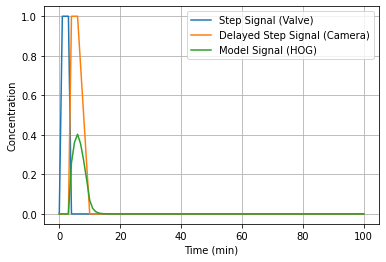

In [14]:
#computes a hog signal as system input
#duration experiment
tend = np.array([100], float)

#pulse start and end 
ton = np.array([1], float)
tdur = np.array([3], float)

#calculo de la expresion y sus respectivos perfiles
inputHOG, tog, perfiles = s2b.HOGexpr(ton, tdur, tend)

#Plotting
plt.figure()
plt.plot(tog, perfiles['t_u_Valve'], label='Step Signal (Valve)')
plt.plot(perfiles['t_u_Chamber'][0], perfiles['t_u_Chamber'][1], label='Delayed Step Signal (Camera)')
plt.plot(tog, inputHOG, label='Model Signal (HOG)')
plt.legend(loc='best')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()
plt.show()


**Solves Differential Equations System**

In [15]:
#replaces values in the simbolic expressions
Vpars = [4.0, 0.010, 1.0, 0.006]

odePars = []
for expr in equations:
  for i in range(0, len(Vpars)):
    expr = expr.subs(parameters[i], Vpars[i])
  #end for i
  odePars.append(expr)
#end for expr

print(odePars)

[4.0*U - 0.01*mRNA, -0.006*Protein + 1.0*mRNA]


In [16]:
def modelODE(z,t,hog):
    #each variable variable changes through iterations
    tempZ = [hog]
    tempZ.extend(z)

    #empty list to store numeric values
    value = []
    
    #evaluates function
    evalue = exp(tempZ)
    value = evalue
        
    return value

#defines function that actually evaluates the expression
exp = sp.lambdify([variables['nameVar']], odePars, "numpy")

#species initial conditions
Sn = len(species)
sp0 = np.zeros(Sn)

#array to store output
valuesSp = np.zeros((Sn, len(tog)))

#attaches initial conditions
valuesSp[:,0] = sp0

#loop to solve the differential equation system
for t in range(1, len(tog)):
    #sets a period of time
    tspan = [tog[t-1], tog[t]]
    
    #solve differential equations system in a period of time
    z = odeint(modelODE,sp0,tspan,args=(inputHOG[t],))
    
    #stores outcome from solving system
    valuesSp[:,t] = z[1,:]
    
    #changes initial conditions for the next iteration
    sp0 = z[1]
#end for t

**System Output**

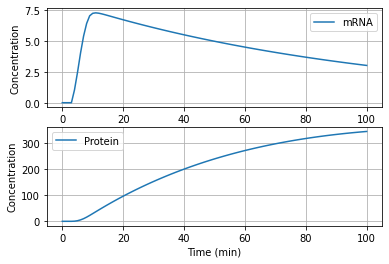

In [17]:
plt.figure()
for s in range(0,len(species)):
    plt.subplot(len(species),1,s+1)
    plt.plot(tog, valuesSp[s,:], label=str(variables["species"][s]))
    plt.xlabel('Time (min)')
    plt.ylabel('Concentration')
    plt.legend(loc='best')
    plt.grid()
plt.show()